# Test regridding using `xgcm`

* Use to regrid from model levels to pressure levels
* Note data outside the limits gets sets to nans - different from regridded data in the UM where outside get set to nearest value I think (check this)

In [1]:
from pathlib import Path

import numpy as np
import xarray as xr
import xgcm

In [2]:
# Warnings mess up my notebooks currently :(
import warnings
warnings.filterwarnings("ignore")

In [3]:
tmpdir = Path('/work/scratch-nopw2/mmuetz/wcrp_hackathon/tmp_iris_conversion')

In [4]:
# Load 3D data
ds3d_p = xr.open_dataset(tmpdir / 'glm.n2560_RAL3p3.3Dpressure_20200120T00.nc')
ds3d_ml = xr.open_dataset(tmpdir / 'glm.n2560_RAL3p3.3Dmodellevel_20200120T00.nc')

In [5]:
ds3d_ml

<xarray.Dataset> Size: 94GB
Dimensions:                                     (time: 5,
                                                 model_level_number: 60,
                                                 latitude: 3840,
                                                 longitude: 5120, bnds: 2)
Coordinates:
  * time                                        (time) datetime64[ns] 40B 202...
  * model_level_number                          (model_level_number) int32 240B ...
  * latitude                                    (latitude) float32 15kB -89.9...
  * longitude                                   (longitude) float32 20kB 0.03...
    forecast_period                             (time) timedelta64[ns] 40B ...
    forecast_reference_time                     datetime64[ns] 8B ...
    level_height                                (model_level_number) float32 240B ...
    sigma                                       (model_level_number) float32 240B ...
Dimensions without coordinates: bnds
Data variables:
    mass_fraction_of_cloud_ice_in_air           (time, model_level_number, latitude, longitude) float32 24GB ...
    latitude_longitude                          int32 4B ...
    level_height_bnds                           (model_level_number, bnds) float32 480B ...
    sigma_bnds                                  (model_level_number, bnds) float32 480B ...
    mass_fraction_of_cloud_liquid_water_in_air  (time, model_level_number, latitude, longitude) float32 24GB ...
    mass_fraction_of_graupel_in_air             (time, model_level_number, latitude, longitude) float32 24GB ...
    mass_fraction_of_rain_in_air                (time, model_level_number, latitude, longitude) float32 24GB ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   13.5
    Conventions:  CF-1.7

In [6]:
pressure_path = tmpdir / 'pressure.nc'
if not pressure_path.exists():
    fn = '/gws/nopw/j04/kscale/DYAMOND3_example_data/sample_data_hirerarchy/5km-RAL3/glm/field.pp/apverc.pp/glm.n2560_RAL3p3.apverc_20200120T00.pp'
    cubes = iris.load(fn)
    cubes
    
    p = cubes.extract_cube('air_pressure')
    
    iris.save(p, pressure_path)

In [7]:
p

NameError: name 'p' is not defined

In [7]:
ds = xr.open_dataset(pressure_path)

In [8]:
ds

<xarray.Dataset> Size: 19GB
Dimensions:                  (time: 4, model_level_number: 60, latitude: 3840,
                              longitude: 5120, bnds: 2)
Coordinates:
  * time                     (time) datetime64[ns] 32B 2020-01-20T03:00:00 .....
  * model_level_number       (model_level_number) int32 240B 1 2 3 ... 58 59 60
  * latitude                 (latitude) float32 15kB -89.98 -89.93 ... 89.98
  * longitude                (longitude) float32 20kB 0.03516 0.1055 ... 360.0
    forecast_period          (time) timedelta64[ns] 32B ...
    forecast_reference_time  datetime64[ns] 8B ...
    level_height             (model_level_number) float32 240B ...
    sigma                    (model_level_number) float32 240B ...
Dimensions without coordinates: bnds
Data variables:
    air_pressure             (time, model_level_number, latitude, longitude) float32 19GB ...
    latitude_longitude       int32 4B ...
    level_height_bnds        (model_level_number, bnds) float32 480B ...
    sigma_bnds               (model_level_number, bnds) float32 480B ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   13.5
    Conventions:  CF-1.7

In [9]:
# Select out a small bit of data and convert Pa to hPa.
ds2 = ds.isel(time=slice(0, 1)).copy()
ds2.air_pressure.values = ds2.air_pressure.values / 100

In [10]:
# Do regridding
grid = xgcm.Grid(ds, coords=dict(pressure={'center': 'model_level_number'}), periodic=False)

cli = grid.transform(
    ds3d_ml.mass_fraction_of_cloud_ice_in_air.isel(time=slice(1, 2)),
    'pressure',
    ds3d_p.pressure.values, 
    target_data=ds2.air_pressure,
    method='linear',
)   
cli

<xarray.DataArray 'mass_fraction_of_cloud_ice_in_air' (time: 1, latitude: 3840,
                                                       longitude: 5120,
                                                       air_pressure: 25)> Size: 2GB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.]]]], dtype=float32)
Coordinates:
  * time                     (time) datetime64[ns] 8B 2020-01-20T03:00:00
  * latitude                 (latitude) float32 15kB -89.98 -89.93 ... 89.98
  * longitude                (longitude) float32 20kB 0.03516 0.1055 ... 360.0
    forecast_period          (time) timedelta64[ns] 8B 03:00:00
    forecast_reference_time  datetime64[ns] 8B 2020-01-20
  * air_pressure             (air_pressure) float32 100B 1.0 5.0 ... 975.0 1e+03

In [11]:
cli = cli.rename(air_pressure='pressure').transpose('time', 'pressure', 'latitude', 'longitude')
cli

<xarray.DataArray 'mass_fraction_of_cloud_ice_in_air' (time: 1, pressure: 25,
                                                       latitude: 3840,
                                                       longitude: 5120)> Size: 2GB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]], dtype=float32)
Coordinates:
  * time                     (time) datetime64[ns] 8B 2020-01-20T03:00:00
  * latitude                 (latitude) float32 15kB -89.98 -89.93 ... 89.98
  * longitude                (longitude) float32 20kB 0.03516 0.1055 ... 360.0
    forecast_period          (time) timedelta64[ns] 8B 03:00:00
    forecast_reference_time  datetime64[ns] 8B 2020-01-20
  * pressure                 (pressure) float32 100B 1.0 5.0 ... 975.0 1e+03

In [12]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


In [13]:
ds2.air_pressure[0, 0].min()

<xarray.DataArray 'air_pressure' ()> Size: 4B
array(450.67624, dtype=float32)
Coordinates:
    time                     datetime64[ns] 8B 2020-01-20T03:00:00
    model_level_number       int32 4B 1
    forecast_period          timedelta64[ns] 8B 03:00:00
    forecast_reference_time  datetime64[ns] 8B 2020-01-20
    level_height             float32 4B ...
    sigma                    float32 4B ...

In [14]:
np.isnan(cli.sel(pressure=600).values).sum()

np.int64(79959)

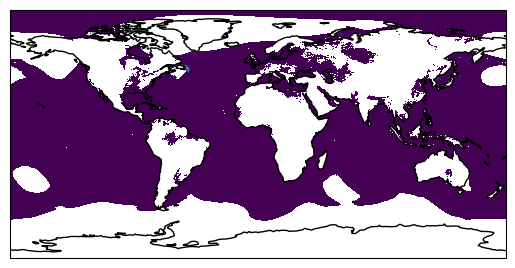

In [15]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.pcolormesh(cli.longitude, cli.latitude, cli.isel(time=0).sel(pressure=1000))
ax.coastlines();

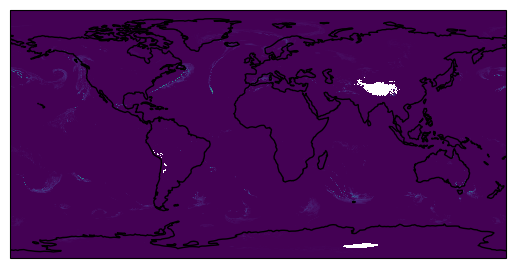

In [16]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.pcolormesh(cli.longitude, cli.latitude, cli.isel(time=0).sel(pressure=600))
ax.coastlines();

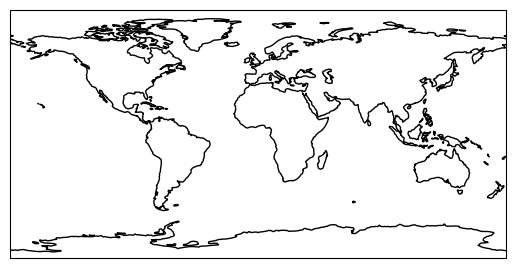

In [17]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.pcolormesh(cli.longitude, cli.latitude, cli.isel(time=0).sel(pressure=1))
ax.coastlines();

In [18]:
ds_small = ds3d_p.isel(time=slice(1)).copy()

In [19]:
# Check I can add this back to a dataset with existing pressure coord and no nuplicate coords etc.
ds_small['cli'] = cli

In [20]:
ds_small

<xarray.Dataset> Size: 16GB
Dimensions:                  (time: 1, pressure: 25, latitude: 3841,
                              longitude: 5120, latitude_0: 3840,
                              longitude_0: 5120)
Coordinates:
  * time                     (time) datetime64[ns] 8B 2020-01-20
  * pressure                 (pressure) float32 100B 1.0 5.0 ... 975.0 1e+03
  * latitude                 (latitude) float32 15kB -90.0 -89.95 ... 89.95 90.0
  * longitude                (longitude) float32 20kB 0.0 0.07031 ... 359.9
  * latitude_0               (latitude_0) float32 15kB -89.98 -89.93 ... 89.98
  * longitude_0              (longitude_0) float32 20kB 0.03516 0.1055 ... 360.0
    forecast_period          (time) timedelta64[ns] 8B ...
    forecast_reference_time  datetime64[ns] 8B ...
Data variables:
    x_wind                   (time, pressure, latitude, longitude) float32 2GB ...
    latitude_longitude       int32 4B ...
    geopotential_height      (time, pressure, latitude_0, longitude_0) float32 2GB ...
    y_wind                   (time, pressure, latitude, longitude) float32 2GB ...
    relative_humidity        (time, pressure, latitude, longitude) float32 2GB ...
    relative_humidity_0      (time, pressure, latitude_0, longitude_0) float32 2GB ...
    air_temperature          (time, pressure, latitude_0, longitude_0) float32 2GB ...
    upward_air_velocity      (time, pressure, latitude_0, longitude_0) float32 2GB ...
    cli                      (time, pressure, latitude, longitude) float32 2GB ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   13.5
    Conventions:  CF-1.7

## Check data interp'd in UM

In [22]:
# NO NANS in data interp'd onto pressure levels from UM!
np.isnan(ds_small.x_wind.values).sum()

np.int64(0)

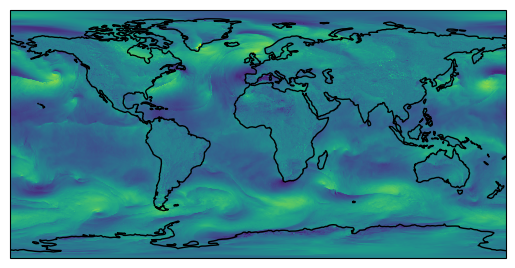

In [23]:
# Sure enough - pressure=1000 hPa has no missing data...
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.pcolormesh(ds_small.longitude, ds_small.latitude, ds_small.x_wind.isel(time=0).sel(pressure=1000))
ax.coastlines();

In [24]:
u = ds_small.x_wind.isel(time=0)

In [25]:
# The values are the same for lots of grid cells - they take the lowest (atm) good value.
(u.isel(pressure=-1).values == u.isel(pressure=-2).values).sum()

np.int64(6951403)

In [26]:
u[0].size

19665920

## Produce a nice string for saving lat/lon data in a filename for weights files

In [27]:
ds_small.latitude

<xarray.DataArray 'latitude' (latitude: 3841)> Size: 15kB
array([-90.      , -89.953125, -89.90625 , ...,  89.90625 ,  89.953125,
        90.      ], dtype=float32)
Coordinates:
  * latitude                 (latitude) float32 15kB -90.0 -89.95 ... 89.95 90.0
    forecast_reference_time  datetime64[ns] 8B ...

In [28]:
ds_small.latitude_0

<xarray.DataArray 'latitude_0' (latitude_0: 3840)> Size: 15kB
array([-89.97656, -89.92969, -89.88281, ...,  89.88281,  89.92969,  89.97656],
      dtype=float32)
Coordinates:
  * latitude_0               (latitude_0) float32 15kB -89.98 -89.93 ... 89.98
    forecast_reference_time  datetime64[ns] 8B ...
Attributes:
    axis:           Y
    units:          degrees_north
    standard_name:  latitude

In [29]:
lat0, lat1, latN = ds_small.latitude.values[[0, 1, -1]]
lon0, lon1, lonN = ds_small.longitude.values[[0, 1, -1]]

In [30]:
lat0.item(), latN.item(), len(ds_small.latitude)

(-90.0, 90.0, 3841)

In [31]:
lon0.item(), lonN.item(), len(ds_small.longitude)

(0.0, 359.9296875, 5120)

In [32]:
str((lon0.item(), lonN.item(), len(ds_small.longitude))).replace(' ', '')

'(0.0,359.9296875,5120)'

# Test2 data as in workflow

In [1]:
import numpy as np

import xarray as xr
import xgcm

In [2]:
ds = xr.open_dataset('/work/scratch-nopw2/mmuetz/wcrp_hackathon/DYAMOND3_example_data/5km-RAL3/20200120T00.3d.nc')

/home/users/mmuetz/miniforge3/envs/hackathon_env/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/tmp/ipykernel_4232/3035529485.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('/work/scratch-nopw2/mmuetz/wcrp_hackathon/DYAMOND3_example_data/5km-RAL3/20200120T00.3d.nc')
/tmp/ipykernel_4232/3035529485.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('/work/scratch-nopw2/mmuetz/wcrp_hackathon/DYAMOND3_example_data/5km-RAL3/20200120T00.3d.nc')


In [28]:
def model_level_to_pressure(da:xr.DataArray, ds:xr.Dataset):
    da_p = ds.air_pressure
    tname1 = [c for c in da.coords if c.startswith('time')][0]
    tname2 = [c for c in da_p.coords if c.startswith('time')][0]
    t1 = da[tname1]
    t2 = da_p[tname2]
    assert len(t1) > len(t2)
    idx = np.argmin(np.abs(t1.values - t2.values[0]))
    #print(idx)
    s = slice(idx, idx + len(t2))
    assert (t1[s].values == t2.values).all()

    da = da.isel(**{tname1: s})
    da_p = da_p.rename(**{tname2: tname1})
    da_p.values /= 100
    
    pressure_values = ds.pressure.values
    ds_p = da_p.to_dataset(name='pressure')
    
    grid = xgcm.Grid(ds_p, coords=dict(pressure={'center': 'model_level_number'}), periodic=False)
    da_pressure_levels = grid.transform(
        da,
        'pressure',
        pressure_values,
        target_data=da_p,
        method='linear',
    )
    return da_pressure_levels

In [29]:
mf = ds.mass_fraction_of_cloud_ice_in_air.isel(latitude_0=slice(10), longitude_0=slice(10))

In [30]:
mf2 = model_level_to_pressure(mf, ds.isel(latitude_0=slice(10), longitude_0=slice(10)))

/home/users/mmuetz/miniforge3/envs/hackathon_env/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


In [32]:
np.isnan(mf2.values).all()

np.False_

In [15]:
ds.air_pressure

<xarray.DataArray 'air_pressure' (time_0: 4, model_level_number: 60,
                                  latitude_0: 3840, longitude_0: 5120)> Size: 19GB
[4718592000 values with dtype=float32]
Coordinates:
    forecast_reference_time  datetime64[ns] 8B ...
  * latitude_0               (latitude_0) float32 15kB -89.98 -89.93 ... 89.98
  * longitude_0              (longitude_0) float32 20kB 0.03516 0.1055 ... 360.0
  * model_level_number       (model_level_number) int32 240B 1 2 3 ... 58 59 60
    level_height             (model_level_number) float32 240B ...
    sigma                    (model_level_number) float32 240B ...
  * time_0                   (time_0) datetime64[ns] 32B 2020-01-20T03:00:00 ...
    forecast_period_0        (time_0) timedelta64[ns] 32B ...
Attributes:
    standard_name:    air_pressure
    units:            Pa
    um_stash_source:  m01s00i408
    grid_mapping:     latitude_longitude

In [17]:
ds.time.values

array(['2020-01-20T00:00:00.000000000', '2020-01-20T03:00:00.000000000',
       '2020-01-20T06:00:00.000000000', '2020-01-20T09:00:00.000000000',
       '2020-01-20T12:00:00.000000000'], dtype='datetime64[ns]')

In [18]:
ds.time_0.values

array(['2020-01-20T03:00:00.000000000', '2020-01-20T06:00:00.000000000',
       '2020-01-20T09:00:00.000000000', '2020-01-20T12:00:00.000000000'],
      dtype='datetime64[ns]')

# Stratify regrid

In [35]:
from functools import partial


from loguru import logger
import iris
from iris.experimental.stratify import relevel
import numpy as np
import stratify

def iris_relevel_model_level_to_pressure(cube, cubes):
    logger.debug(f're-level model level to {cube}')
    p = cubes.extract_cube('air_pressure')
    cube = cube[-p.shape[0]:]
    assert (p.coord('time').points == cube.coord('time').points).all()

    z = cubes.extract_cube('specific_humidity')
    pressure_levels = z.coord('pressure').points[::-1] * 100  # convert from hPa to Pa.
    interpolator = partial(stratify.interpolate,
                           interpolation=stratify.INTERPOLATE_LINEAR,
                           extrapolation=stratify.EXTRAPOLATE_LINEAR,
                           rising=False)
    new_cube_data = np.zeros((cube.shape[0], len(pressure_levels), cube.shape[2], cube.shape[3]))
    for i in range(cube.shape[0]):
        logger.trace(i)
        regridded_cube = relevel(cube[i], p[i], pressure_levels, interpolator=interpolator)
        logger.trace('regridded_cube.data.sum()', regridded_cube.data.sum())
        new_cube_data[i] = regridded_cube.data
        # TODO: DO NOT LEAVE IN!!
        break
    coords = [(cube.coord('time'), 0), (z.coord('pressure'), 1), (cube.coord('latitude'), 2), (cube.coord('longitude'), 3)]
    new_cube = iris.cube.Cube(new_cube_data,
                              long_name=cube.name(),
                              units=cube.units,
                              dim_coords_and_dims=coords,
                              attributes=cube.attributes)
    logger.trace(new_cube)
    return new_cube

In [2]:
from pathlib import Path


In [3]:
basedir = Path('/gws/nopw/j04/kscale/DYAMOND3_example_data/sample_data_hirerarchy/5km-RAL3/glm/field.pp')

In [4]:
cubes = iris.load(basedir / 'apverc.pp' / 'glm.n2560_RAL3p3.apverc_20200120T00.pp')
cubes

/home/users/mmuetz/miniforge3/envs/hackathon_env/lib/python3.12/site-packages/iris/fileformats/rules.py:371: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(
/home/users/mmuetz/miniforge3/envs/hackathon_env/lib/python3.12/site-packages/iris/common/mixin.py:195: FutureWarning: You are using legacy date precision for Iris units - max precision is seconds. In future, Iris will use microsecond precision - available since cf-units version 3.3 - which may affect core behaviour. To opt-in to the new behaviour, set `iris.FUTURE.date_microseconds = True`.
  warnings.warn(message, category=FutureWarning)


Mass Fraction Of Cloud Ice Crystals In Air (kg kg-1),time,model_level_number,latitude,longitude
Shape,5,60,3840,5120
Dimension coordinates,,,,
time,x,-,-,-
model_level_number,-,x,-,-
latitude,-,-,x,-
longitude,-,-,-,x
Auxiliary coordinates,,,,
forecast_period,x,-,-,-
level_height,-,x,-,-
sigma,-,x,-,-


In [5]:
cube = cubes.extract_cube('mass_fraction_of_cloud_ice_in_air')
cube[1, :, 2000:2010, 2000:2010].data.sum()

np.float32(0.00012922287)

In [7]:
cube = cube[1:2, :, 2000:2010, 2000:2010]
cube.shape

(1, 60, 10, 10)

In [18]:
pcubes = iris.cube.CubeList([cubes.extract_cube('air_pressure')[:1, :, 2000:2010, 2000:2010], cubes.extract_cube('specific_humidity')[:1, :, 2000:2010, 2000:2010]])
pcubes

Air Pressure (Pa),time,model_level_number,latitude,longitude
Shape,1,60,10,10
Dimension coordinates,,,,
time,x,-,-,-
model_level_number,-,x,-,-
latitude,-,-,x,-
longitude,-,-,-,x
Auxiliary coordinates,,,,
forecast_period,x,-,-,-
level_height,-,x,-,-
sigma,-,x,-,-


In [9]:
cube.data.sum()

np.float32(0.00012922287)

In [36]:
nc = iris_relevel_model_level_to_pressure(cube, pcubes)

2025-03-19 15:02:22.171 | DEBUG    | __main__:iris_relevel_model_level_to_pressure:11 - re-level model level to mass_fraction_of_cloud_ice_in_air / (kg kg-1) (time: 1; model_level_number: 60; latitude: 10; longitude: 10)
    Dimension coordinates:
        time                                       x                      -             -              -
        model_level_number                         -                      x             -              -
        latitude                                   -                      -             x              -
        longitude                                  -                      -             -              x
    Auxiliary coordinates:
        forecast_period                            x                      -             -              -
        level_height                               -                      x             -              -
        sigma                                      -                      x             -      

In [37]:
cube.data.sum()

np.float32(0.00012922287)

In [38]:
nc.data.sum()

np.float64(2.8732406928355658e-05)

In [39]:
pcubes[0].data.mean(axis=(0, 2, 3))

array([100828.73  , 100452.37  ,  99927.06  ,  99254.53  ,  98436.87  ,
        97476.74  ,  96377.22  ,  95141.82  ,  93774.7   ,  92280.61  ,
        90664.92  ,  88935.21  ,  87099.31  ,  85164.06  ,  83136.56  ,
        81023.734 ,  78833.37  ,  76573.15  ,  74249.57  ,  71874.13  ,
        69455.35  ,  66993.65  ,  64494.836 ,  61970.64  ,  59431.023 ,
        56881.465 ,  54334.12  ,  51797.55  ,  49278.41  ,  46787.05  ,
        44328.574 ,  41908.26  ,  39527.41  ,  37187.57  ,  34892.844 ,
        32647.766 ,  30457.625 ,  28327.633 ,  26261.78  ,  24264.39  ,
        22340.09  ,  20493.314 ,  18728.04  ,  17046.477 ,  15446.17  ,
        13928.452 ,  12502.807 ,  11177.466 ,   9954.232 ,   8827.084 ,
         7791.444 ,   6860.956 ,   6043.6025,   5325.7275,   4690.7773,
         4125.3164,   3620.345 ,   3169.7324,   2766.7737,   2405.795 ],
      dtype=float32)

In [34]:
pcubes[1].coord('pressure').points * 100

array([   100.,    500.,   1000.,   2000.,   3000.,   5000.,   7000.,
        10000.,  15000.,  20000.,  25000.,  30000.,  40000.,  50000.,
        60000.,  70000.,  75000.,  80000.,  85000.,  87500.,  90000.,
        92500.,  95000.,  97500., 100000.], dtype=float32)

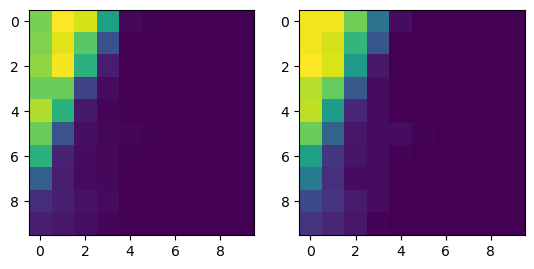

In [41]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
axes[0].imshow(cube.data.sum(axis=(0, 1)))
axes[1].imshow(nc.data.sum(axis=(0, 1)))